# **Rice Disease Detection**
Rice farming is a vital sector for the country’s economy and food security, the prevalence of diseases such as blast and leaf blight poses a significant threat, often leading to major crop losses. Farmers often lack access to reliable information and modern diagnostic tools, instead relying on experience or manual methods that may not yield accurate results.

Therefore, we want to develop a model that can detect rice diseases such as bacterial blight, blast, brown spot, and tungro using datasets taken from kaggle so that it can detect rice diseases based on input images

# **About Dataset**

This project uses three main datasets, namely **random-image-sample-dataset**, **blur-dataset**, and **rice-leaf-disease-image**. The **random-image-sample-dataset** and **blur-dataset** are placed in the Dataset/non_paddy directory, while the **rice-leaf-disease-image** dataset is located in the Dataset/Paddy directory. The structure of these datasets is systematically designed to ensure that each class is well-organized, thus facilitating the process of model training and performance evaluation effectively.

# **IMPORT LIBRARY**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Cek versi untuk setiap library
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

print("matplotlib version:", matplotlib.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("tensorflow version:", tf.__version__)

matplotlib version: 3.8.0
numpy version: 1.26.4
pandas version: 2.2.2
seaborn version: 0.13.2
tensorflow version: 2.17.1


# **Downloading the Dataset**

In [ ]:
# Install Kaggle library
# Prerequisite: Upload your Kaggle API key (kaggle.json)
# Make sure you have obtained the API key from Kaggle (https://www.kaggle.com/docs/api#getting-started-installation-&-authentication)
!pip install -q kaggle

# Upload Kaggle API key (kaggle.json)
from google.colab import files
files.upload()

In [ ]:
# Create directory for the Kaggle API key
!mkdir -p ~/.kaggle

# Copy the Kaggle API key to the appropriate directory
!cp kaggle.json ~/.kaggle

# Set appropriate permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

# Download the DermNet dataset using the Kaggle API
!kaggle datasets download -d 'nirmalsankalana/rice-leaf-disease-image'

# Download the dataset non paddy 1
!kaggle datasets download -d 'pankajkumar2002/random-image-sample-dataset'

# Download the non paddy 2
!kaggle datasets download -d 'kwentar/blur-dataset'

Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/rice-leaf-disease-image
License(s): CC0-1.0
 99% 193M/195M [00:10<00:00, 27.1MB/s]
100% 195M/195M [00:10<00:00, 19.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/pankajkumar2002/random-image-sample-dataset
License(s): unknown
 99% 42.0M/42.5M [00:02<00:00, 21.1MB/s]
100% 42.5M/42.5M [00:02<00:00, 14.9MB/s]
Dataset URL: https://www.kaggle.com/datasets/kwentar/blur-dataset
License(s): CC0-1.0
100% 1.49G/1.49G [01:10<00:00, 25.7MB/s]
100% 1.49G/1.49G [01:10<00:00, 22.7MB/s]


# **Data Extraction**

In [ ]:
# Extract all downloaded datasets
datasets = [
    "rice-leaf-disease-image.zip",
    "random-image-sample-dataset.zip",
    "blur-dataset.zip"
]

for dataset in datasets:
    with zipfile.ZipFile(dataset, 'r') as zip_ref:
        zip_ref.extractall(os.path.splitext(dataset)[0])  # Create a folder based on the dataset name

# **Delete File Zip**

In [ ]:
os.remove("/content/blur-dataset.zip")
os.remove("/content/random-image-sample-dataset.zip")
os.remove("/content/rice-leaf-disease-image.zip")


# **Make Direktori [Dataset]**


In [ ]:
def copy_dataset(source_dir, target_dir):
    if os.path.exists(source_dir):
        for item in os.listdir(source_dir):
            source_path = os.path.join(source_dir, item)
            target_path = os.path.join(target_dir, item)
            if os.path.isdir(source_path):
                shutil.copytree(source_path, target_path, dirs_exist_ok=True)
            else:
                shutil.copy2(source_path, target_path)
    else:
        print(f"Source directory '{source_dir}' not found.")

In [ ]:
# Path dataset
rice_leaf_dir = "rice-leaf-disease-image"
random_image_dir = "random-image-sample-dataset"
blur_dir = "blur-dataset"
output_dir = "Dataset"

# Destination directory
paddy_dir = os.path.join(output_dir, "paddy")
non_paddy_dir = os.path.join(output_dir, "non_paddy")

# Create an output directory
os.makedirs(paddy_dir, exist_ok=True)
os.makedirs(non_paddy_dir, exist_ok=True)

In [ ]:
# Copying the rice-leaf-disease-image dataset to the paddy directory
copy_dataset(rice_leaf_dir, paddy_dir)

# Copying the random-image-sample-dataset/data dataset to the non_paddy subdirectory
copy_dataset(random_image_dir, non_paddy_dir)

# Copy the blur-dataset dataset to the non_paddy subdirectories.
copy_dataset(blur_dir, non_paddy_dir)

# **Augmentation Data**

In [ ]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
		    # Specify the input shape.
        tf.keras.Input(shape=(224,224,3)),
        # Add the augmentation layers
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.4, fill_mode='nearest'),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
        tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    ])
    return augmentation_model

In [ ]:
augmentation_model = create_augmentation_model()

# **Load and Preprocess Image**

In [ ]:
# Functions for loading and processing images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    return image, label

#**NOTE**
From the directory structure that has been created, we develop two models to support the detection process in stages. The **first model** is designed to detect whether the image uploaded by the user is an image of a plant, specifically a rice leaf, or not. To develop this model, we use **transfer learning** and **fine-tuning** on a previously trained model by adjusting our dataset. If the first model identifies that the image is a rice plant, the next process is continued to the **second model**.

The **second model** is tasked with detecting the type of disease found in the rice leaf, so that it can provide more specific results to assist further analysis. The **architecture** of the **second model** is completely self-made, adjusted to the characteristics of the dataset and the purpose of detecting diseases in rice plants.

# **Model 1 (Detection Image Non Plant)**


In [ ]:
# Set the path to the dataset directory
paddy_dir = "Dataset/paddy"
non_paddy_dir = "Dataset/non_paddy"

# Function to count the number of files in a directory (including its subdirectories)
def count_files_in_dir(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Counting the number of files
paddy_count = count_files_in_dir(paddy_dir)
non_paddy_count = count_files_in_dir(non_paddy_dir)

# Print the total images
print(f"Number of files in the 'paddy' directory: {paddy_count}")
print(f"Number of files in the 'non_paddy' directory: {non_paddy_count}")

Number of files in the 'paddy' directory: 5932
Number of files in the 'non_paddy' directory: 5100


In [ ]:
# Group image paths into list image_paths [paddy,non_paddy] and labeling

# Initialize a list to store the number of images for each class.
image_paths = []
labels = []

# Processing folder 'paddy'
for class_idx, class_name in enumerate(os.listdir(os.path.join(output_dir, 'paddy'))):
    class_folder = os.path.join(output_dir, 'paddy', class_name)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            # Ensure only valid image files
            if os.path.isfile(image_path) and image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(0)  # Label for 'paddy'

# Processing folder 'non_paddy'
for class_idx, class_name in enumerate(os.listdir(os.path.join(output_dir, 'non_paddy'))):
    class_folder = os.path.join(output_dir, 'non_paddy', class_name)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            # Ensure only valid image files
            if os.path.isfile(image_path) and image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(1)  # Label for 'non_paddy'

# Converting to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

**Split Data**

In [ ]:
# Split stratified train(80%):validation(10%):test(10%)
# X_temp and y_temp is Temporary data and label for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Creating a TensorFlow dataset from paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Preprocessing dataset
train_dataset = train_dataset.map(load_and_preprocess_image)
valid_dataset = valid_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)

# Normalisasi dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimisasi datasets
training_dataset_final = (train_dataset
                          .cache()
                          .shuffle(1000)
                          .batch(32)
                          .prefetch(tf.data.AUTOTUNE))

validating_dataset_final = (valid_dataset
                            .cache()
                            .batch(32)
                            .prefetch(tf.data.AUTOTUNE))

testing_dataset_final = (test_dataset
                         .cache()
                         .batch(32)
                         .prefetch(tf.data.AUTOTUNE))

# Print the number of images in each set.
print(f"Number of images in train set: {len(X_train)}")
print(f"Number of images in validation set: {len(X_valid)}")
print(f"Number of images in test set: {len(X_test)}")

# Ensuring the dataset is valid
for image, label in training_dataset_final.take(1):
    print(f"Image batch shape: {image.shape}, Label batch shape: {label.shape}")

Number of images in train set: 7985
Number of images in validation set: 998
Number of images in test set: 999
Image batch shape: (32, 224, 224, 3), Label batch shape: (32,)


**Model Building and Architecture Configuration**

In [ ]:
# Load the NASNetMobile model pretrained on ImageNet
base_model= NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "nasnet_mobile"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activat

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 4,232,978 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [ ]:
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build the custom classification layers on top of the pre-trained base model
model_non_paddy = tf.keras.Sequential([
    augmentation_model,
    base_model,
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_non_paddy.summary()

# Compile the model with Adam optimizer, a learning rate of 1e-3, binary_crossentropy loss, and accuracy metric
model_non_paddy.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping to monitor validation loss, with a minimum change of 0.001 and a patience of 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ nasnet_mobile (Functional)           │ (None, 7, 7, 1056)          │       4,269,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 32)            │         304,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,610,997 (17.59 MB)

 Trainable params: 341,281 (1.30 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

**Model Training**

In [ ]:
# Train the model and Set a maximum of 15 epochs and include the early stopping callback
history = model_non_paddy.fit(training_dataset_final, epochs=15, validation_data=validating_dataset_final, callbacks=[early_stopping])

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 939s 4s/step - accuracy: 0.8990 - loss: 1.4314 - val_accuracy: 0.9910 - val_loss: 0.3141
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 896s 4s/step - accuracy: 0.9823 - loss: 0.2701 - val_accuracy: 0.9930 - val_loss: 0.1209
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 902s 4s/step - accuracy: 0.9843 - loss: 0.1117 - val_accuracy: 0.9920 - val_loss: 0.0613
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 975s 4s/step - accuracy: 0.9901 - loss: 0.0638 - val_accuracy: 0.9940 - val_loss: 0.0408
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 969s 4s/step - accuracy: 0.9911 - loss: 0.0543 - val_accuracy: 0.9930 - val_loss: 0.0314
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 889s 4s/step - accuracy: 0.9891 - loss: 0.0445 - val_accuracy: 0.9920 - val_loss: 0.0289
Epoch 7/15
177/250 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - accuracy: 0.9929 - loss: 0.0377

**Fine Tuning**

In [ ]:
# Make the last 10 layers of base model trainable
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compile the model with a lower learning rate
model_non_paddy.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-9)

# Train the model with the defined callbacks
history = model_non_paddy.fit(training_dataset_final, epochs=50, validation_data=validating_dataset_final,callbacks=[early_stopping, reduce_lr])


**Model Evaluation Non Paddy**

In [ ]:
# Function to smooth curves
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Apply smoothing to accuracy and loss values
acc = smooth_curve(history.history['accuracy'], factor=0.9)
val_acc = smooth_curve(history.history.get('val_accuracy', []), factor=0.9)
loss = smooth_curve(history.history['loss'], factor=0.9)
val_loss = smooth_curve(history.history.get('val_loss', []), factor=0.9)

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot smoothed accuracy
ax[0].plot(epochs, acc, 'r', label='Training Accuracy', antialiased=True)
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy', antialiased=True)
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([min(min(acc), min(val_acc)) - 0.01, max(max(acc), max(val_acc)) + 0.01])  # Adjust y-axis dynamically
ax[0].legend()
ax[0].grid(True)  # Add grid for better readability

# Plot smoothed loss
ax[1].plot(epochs, loss, 'r', label='Training Loss', antialiased=True)
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss', antialiased=True)
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([min(min(loss), min(val_loss)) - 0.005, max(max(loss), max(val_loss)) + 0.005])  # Adjust y-axis dynamically
ax[1].legend()
ax[1].grid(True)  # Add grid for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to make sure everything fits well
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Generate predictions on the test set
predictions = model_non_paddy.predict(testing_dataset_final)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary classes

# Extract true classes directly from the dataset
true_classes = np.concatenate([y.numpy() for x, y in testing_dataset_final], axis=0)

# Define class names
class_names = ["Paddy", "Non Paddy"]

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

print("\nConfusion Matrix:")
print(conf_matrix_df)

**Save Model 1**

In [ ]:
import pickle

converter = tf.lite.TFLiteConverter.from_keras_model(model_non_paddy)
tflite_model = converter.convert()

In [ ]:
# save model
with open('converted_model1_detect_non_plant.tflite','wb') as f:
    f.write(tflite_model)

# **Model 2 (Rice_Disease)**

In [ ]:
# Get the list of class names (assuming each subdirectory represents a class)
class_names = sorted(os.listdir(paddy_dir))

# Initialize lists to store the number of images for each class
data_counts = []

# Iterate over each class
for class_name in class_names:
    # Count the number of images in the train directory for the current class
    class_dir = os.path.join(paddy_dir, class_name)
    data_count = len(os.listdir(class_dir))
    data_counts.append(data_count)

# Print the total images for each class with the class name
for class_name, count in zip(class_names, data_counts):
    print(f"{class_name}: {count} images")

Bacterialblight: 1584 images
Blast: 1440 images
Brownspot: 1600 images
Tungro: 1308 images


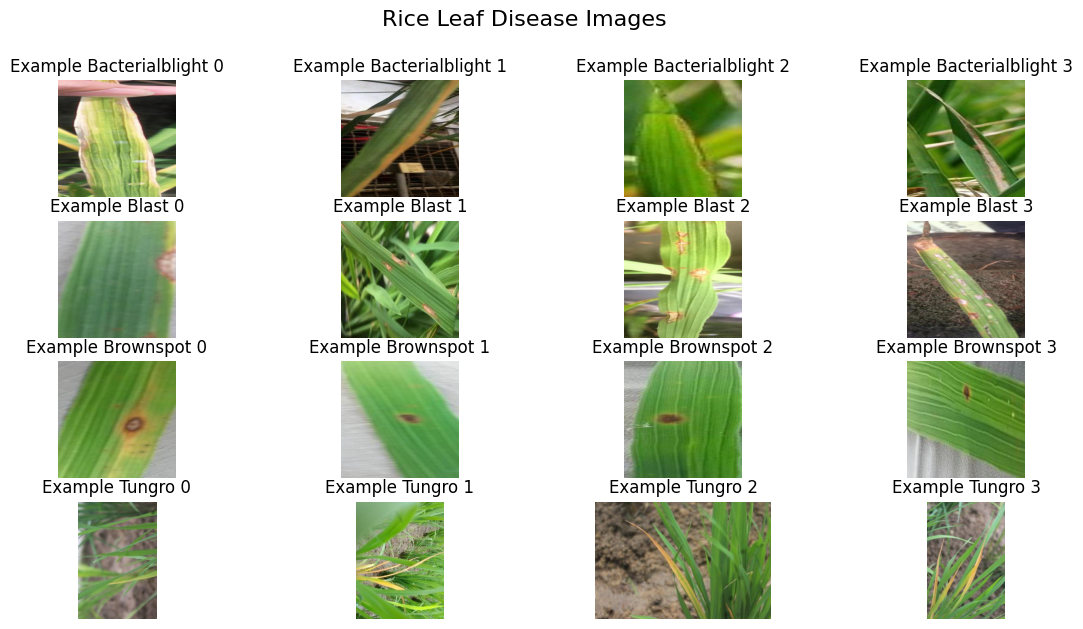

In [ ]:
# Get the filenames for disease images
Bacterialblight_filenames = [os.path.join(paddy_dir, 'Bacterialblight',filename) for filename in os.listdir(os.path.join(paddy_dir, 'Bacterialblight'))]
Blast_filenames = [os.path.join(paddy_dir, 'Blast',filename) for filename in os.listdir(os.path.join(paddy_dir, 'Blast'))]
Brownspot_filenames = [os.path.join(paddy_dir, 'Brownspot',filename) for filename in os.listdir(os.path.join(paddy_dir, 'Brownspot'))]
Tungro_filenames = [os.path.join(paddy_dir, 'Tungro',filename) for filename in os.listdir(os.path.join(paddy_dir, 'Tungro'))]

fig, axes = plt.subplots(4, 4, figsize=(14, 7))
fig.suptitle('Rice Leaf Disease Images', fontsize=16)

# Plot the first 4 images of each class
for i, Bacterialblight_image in enumerate(Bacterialblight_filenames[:4]):
    img = tf.keras.utils.load_img(Bacterialblight_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Bacterialblight {i}')
    axes[0, i].axis('off')  # Hide axes

for i, Blast_image in enumerate(Blast_filenames[:4]):
    img = tf.keras.utils.load_img(Blast_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Blast {i}')
    axes[1, i].axis('off')  # Hide axes

for i, Brownspot_image in enumerate(Brownspot_filenames[:4]):
    img = tf.keras.utils.load_img(Brownspot_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example Brownspot {i}')
    axes[2, i].axis('off')  # Hide axes

for i, Tungro_image in enumerate(Tungro_filenames[:4]):
    img = tf.keras.utils.load_img(Tungro_image)
    axes[3, i].imshow(img)
    axes[3, i].set_title(f'Example Tungro {i}')
    axes[3, i].axis('off')  # Hide axes


plt.show()

**Split dataset/paddy (Rice Disease)**

In [ ]:
# Functions to perform one-hot coding on labels
def one_hot_encode(label):
    return tf.one_hot(label, depth=4)  # Adjust the 'depth' to the number of existing classes

In [ ]:
# Manually load dataset for stratified partitioning
# Can use os to fetch file path and labels
image_paths = []
labels = []

for class_idx, class_name in enumerate(os.listdir(paddy_dir)):
    class_folder = os.path.join(paddy_dir, class_name)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, image_name))
            labels.append(class_idx)

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Perform a stratified split, 80% for train, 10% for validation, 10% for test.
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create datasets from image paths and labels for train, validation, and test.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# preprocessdataset
train_dataset = train_dataset.map(load_and_preprocess_image)
valid_dataset = valid_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)

# Preprocess dataset with one-hot encoding
train_dataset = train_dataset.map(lambda x, y: (x, one_hot_encode(y)))
valid_dataset = valid_dataset.map(lambda x, y: (x, one_hot_encode(y)))
test_dataset = test_dataset.map(lambda x, y: (x, one_hot_encode(y)))

# Normalisasi dataset with Rescaling layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize the datasets
train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(1000)
                       .batch(32)
                       .prefetch(tf.data.AUTOTUNE)
                       )

validation_dataset_final = (valid_dataset
                       .cache()
                       .batch(32)
                       .prefetch(tf.data.AUTOTUNE)
                       )

test_dataset_final = (test_dataset
                      .cache()
                      .batch(32)
                      .prefetch(tf.data.AUTOTUNE)
                      )

# Print the number of images for train, validation, and test.
print(f"Number of images in train set(rice disease): {len(X_train)}")
print(f"Number of images in validation set(rice disease): {len(X_valid)}")
print(f"Number of images in test set(rice disease): {len(X_test)}")


Number of images in train set(rice disease): 4745
Number of images in validation set(rice disease): 593
Number of images in test set(rice disease): 594


**Model Building and Architecture Configuration**

In [ ]:
# Define the CNN model architecture
def create_model():
    #Get the augmentation layers (or model) from your earlier function
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),
        # Add the augmentation layers directly
        augmentation_model,
        # Convolution and Pooling layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),

        # Output layer with 4 neurons, according to the number of classes
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
              optimizer = tf.optimizers.Adam(learning_rate=1e-4),
              metrics = ['accuracy'])
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,680,580 (36.93 MB)

 Trainable params: 9,680,580 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Check Data Shape, Get one batch of data from train_dataset_final
for example_batch_images, example_batch_labels in train_dataset_final.take(1):
    print("Shape of example_batch_images:", example_batch_images.shape)
    print("Shape of example_batch_labels:", example_batch_labels.shape)

Shape of example_batch_images: (32, 224, 224, 3)
Shape of example_batch_labels: (32, 4)


**Training Model**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_dataset_final,
    validation_data=validation_dataset_final,
    epochs=50,
    verbose=2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


KeyboardInterrupt: 

**Model Evaluation**

In [ ]:
# Function to smooth curves
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Apply smoothing to accuracy and loss values
acc = smooth_curve(history.history['accuracy'])
val_acc = smooth_curve(history.history.get('val_accuracy', []))
loss = smooth_curve(history.history['loss'])
val_loss = smooth_curve(history.history.get('val_loss', []))

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot smoothed accuracy
ax[0].plot(epochs, acc, 'r', label='Training accuracy', antialiased=True)
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy', antialiased=True)
ax[0].set_title('Training and validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot smoothed loss
ax[1].plot(epochs, loss, 'r', label='Training Loss', antialiased=True)
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss', antialiased=True)
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

In [ ]:
# Generate prediction on the test set
predictions = model.predict(test_dataset_final)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(np.concatenate([y.numpy() for x, y in test_dataset_final], axis=0), axis=1)
class_names = ["Bacterialblight", "Blast", "Brownspot", "Tungro"]

# Classification Report with class name
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion Matrix with class name
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

print("\nConfusion Matrix:")
print(conf_matrix_df)

**Save Model 2**

In [ ]:
import pickle
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# save model
with open('converted_model2_rice_disease.tflite','wb') as f:
    f.write(tflite_model)

# **Predictions**

In [ ]:
import numpy as np
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt

# **Step 1: Loading TFLite model**
# Model 1 (Detection Image Non Plant)
interpreter_paddy = tf.lite.Interpreter(model_path='converted_model1_detect_non_plant.tflite')
interpreter_paddy.allocate_tensors()
input_details_paddy = interpreter_paddy.get_input_details()
output_details_paddy = interpreter_paddy.get_output_details()

# Model 2(Rice Disease)
interpreter_disease = tf.lite.Interpreter(model_path='converted_model2_rice_disease.tflite')
interpreter_disease.allocate_tensors()
input_details_disease = interpreter_disease.get_input_details()
output_details_disease = interpreter_disease.get_output_details()

# **Langkah 2: Upload Image**
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# List Class
class_names_paddy = ["Paddy", "Non Paddy"]
class_names_disease = ["Bacterialblight", "Blast", "Brownspot", "Tungro"]

# Reading and preparing images for prediction
img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0  # Normalisasi

# **Step 3: Prediction with the first model**
x_paddy = x.astype(input_details_paddy[0]['dtype'])
interpreter_paddy.set_tensor(input_details_paddy[0]['index'], x_paddy)
interpreter_paddy.invoke()
output_paddy = interpreter_paddy.get_tensor(output_details_paddy[0]['index'])
predicted_probability_paddy = output_paddy[0][0]  # Output sigmoid
predicted_class_paddy = class_names_paddy[1] if predicted_probability_paddy > 0.5 else class_names_paddy[0]

# Displaying prediction results
print("Predicted class (Paddy vs Non Paddy):", predicted_class_paddy)

# **Step 4: If Rice, use the second model for disease prediction.**
if predicted_class_paddy == "Paddy":
    x_disease = x.astype(input_details_disease[0]['dtype'])
    interpreter_disease.set_tensor(input_details_disease[0]['index'], x_disease)
    interpreter_disease.invoke()
    output_disease = interpreter_disease.get_tensor(output_details_disease[0]['index'])
    predicted_class_index_disease = np.argmax(output_disease[0])
    predicted_class_disease = class_names_disease[predicted_class_index_disease]

    # Displaying disease prediction results
    print("Predicted disease in Paddy:", predicted_class_disease)
else:
    print("This is not a Paddy, so no disease prediction needed and please upload an image of a paddy plant.")

# Showing images
plt.imshow(tf.keras.utils.load_img(image_path))
plt.axis('off')
plt.show()